# Object Detection And Classification For Species Recognition

## Problem Statement

Around 12% of current bird species are considered endangered, threatened or vulnerable in some way. Many birds play a crucial roll in ecological systems for both predator and prey. Bird species such as these are known as 'keystone species' that hold an invaluable presence in their respective ecosystems. For example, a lot of birds are host to a variety of parasites and flys that also hold weight within their food chains. Additionally, many birds aid in pollination of certain plant species and creation of subhabitats such as nests or entry points in trees (woodpecker). It is incredibly important to conserve these species for both ecological and humane reasons. Not to mention, birds are peculiar and amusing to us. It would be a shame to go out on a walk and not hear the specific chirping melody based on the regional species.  
What we can do is propose a habitat protection movement. Habitat loss and destruction are one of the leading causes of bird species extinction. We can discretely place cameras in areas we know there may be endangered species and are being considered for deforestation or other means of habitat disruption. We will attempt to train our own bird detection system so that we can appropriately assess the population and activity of specific species within our geographical regions of study. Working with local governments and species conservation groups, we can present our data and work against habitat loss.

## Executive Summary

We used a combination of images from Cal-Tech's bird data set and a basic google image search of certain species. Cal-Tech's bird data set includes 200 species of around 80 images per species. We have abridged the dataset to 3 species of around 80 images per species. The intended outcome of our study is to analyze various methods of segmentation and object detection, as opposed to produced a highly accurate bird classification model (although we will include classification). Image segmentation allows us to extract and separate different regions within our image. We are going to apply two segmentation approaches, a selective search approach and a histogram of oriented gradients approach. We will then apply and evaluate various classification algorithms that will help us determine which segments are of interest (bird) and which are not (background noise, other animals,..so on)



Selective Search
- Diverse application of grouping/segmentation algorithms based on color/texture/shape  
- Proposes multiple regions of interest  
- heirarchical 

HOG
- Represents images as a single feature vector as opposed to a bunch of feature vectors with each vector representing a segment of the image. 
- sliding a window detector over the image, somewhat similar to CNN. 

As with many image recognition and object detection problems, we run into many recurrent and expected problems. We must consider how we will account for birds with different poses, facing different directions, leaning forwards or backwards, facing the camera or facing away, flying or standing, and so on. If we feed in images of birds in only certain poses, lets say all facing left, how will our detection system recognize a bird facing right. We also have to considered different background classes. Different bird species will habit different genres of terrain(what region are these species found in), and similarly we have to account for what season it is, weather conditions, time of day, lighting, etc.. We have accounted for some of these issues with data augmentation where we have generated copies of our original data with added noise that can be considered synonymous with camera inconsistencies (scratching,dust) and orientation flips (pose left,right). Our augmentation was minimal given time constraints and annotations, so we are avoiding rotation.

For both approaches, we fit and evaluated various classification algorithms in a binary setting (foreground,background). We use our annotated boundary boxes on our birds so we can retrieve suggested candidate regions for foreground objects. We calculated an Intersection over Union score (IoU) to determine how overlapped our proposed regions by our segmentation are with our ground truth (annoted labels) box. Regions with a score greater than 0.7 would be classified as foreground and regions with a score less than 0.3 would be classified as background. Scores between 0.7 and 0.3 are ignored. Our classification models include SVC, KNN, and LogisticRegression. 


## Building a Region-based CNN

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import cv2

from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score



# import keras
# from keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Flatten,Dense, ZeroPadding2D, Dropout, Input
from keras.preprocessing.image import ImageDataGenerator
from keras.engine.topology import Layer
# import keras.backend as K
# import keras.layers as KL
# import keras.models as KM

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Flatten,Dense,Dropout


import xml.etree.ElementTree as ET


In [2]:
train_path='./data/bird2_train/'
test_path='./data/bird2_test/'

## Read in CVAT annotion file with XML parser

In [3]:
def create_df_xml(input1):
    annotation=ET.parse(f'./data/bird2_{input1}/{input1}_annotations.xml')
    root=annotation.getroot()
    df_cols=['root','filename','w','h']
    df_rows=[]
    for node in root.iter('image'):
        #print (list(node.attrib.values()))
        s_root=f'/data/bird2_{input1}/'
        s_name=list(node.attrib.values())[1]
        s_height=list(node.attrib.values())[3]
        s_width=list(node.attrib.values())[2]
         
        
    
        df_rows.append({'root':s_root,'filename': s_name,'w':s_width,'h':s_height,
                            })
        x1=pd.DataFrame(df_rows, columns = df_cols)
    df_cols=['x1','x2','y1','y2','label']
    df_rows=[]
    for node in root.iter('image'):
        for node1 in node:
            s_x1=list(node1.attrib.values())[2]
            s_x2=list(node1.attrib.values())[4]
            s_y1=list(node1.attrib.values())[3]
            s_y2=list(node1.attrib.values())[5]
            s_label=list(node1.attrib.values())[0]
            df_rows.append({
                            'x1':s_x1,'x2':s_x2,'y1':s_y1,'y2':s_y2,'label':s_label})
        x2=pd.DataFrame(df_rows,columns=df_cols)
    x4= pd.concat((x1,x2),axis=1)  
    annotation=ET.parse(f'./data/bird2_{input1}/{input1}_parts.xml')
    root=annotation.getroot()
    
    
    df_cols=['wing']
    df_rows=[]
    for node in root.iter('image'):
        #s_name=list(node.attrib.values())[1]
        for node1 in node:
            #print(node1.attrib)
            for node2 in node1:
    
                if node2.text=='wing':
                    s_wing=node1.attrib
                    
                #print(node2.text)
                #print('hi')
                    df_rows.append({
                                'wing':s_wing})
            x1=pd.DataFrame(df_rows,columns=df_cols)
    
    df_cols=['head']
    df_rows=[]
    for node in root.iter('image'):
        #s_name=list(node.attrib.values())[1]
        for node1 in node:
            #print(node1.attrib)
            for node2 in node1:
    
                if node2.text=='head':
                    s_head=node1.attrib
                    
                #print(node2.text)
                #print('hi')
                    df_rows.append({
                                'head':s_head})
            x2=pd.DataFrame(df_rows,columns=df_cols)
    x3=pd.concat((x1,x2),axis=1)
    return pd.concat((x4,x3),axis=1)

In [4]:
test1=create_df_xml('test')
train1=create_df_xml('train')

In [5]:
train1.head()

,root,filename,w,h,x1,x2,y1,y2,label,wing,head
0,/data/bird2_train/,70095201-480px.jpg,480,360,6.72,422.55,67.11,308.78,BFA,"{'label': 'BFA', 'occluded': '0', 'xtl': '75.6...","{'label': 'BFA', 'occluded': '0', 'xtl': '252...."
1,/data/bird2_train/,Black_Footed_Albatross_0002_55.jpg,500,347,12.04,403.98,109.90,298.88,BFA,"{'label': 'BFA', 'occluded': '0', 'xtl': '42.1...","{'label': 'BFA', 'occluded': '0', 'xtl': '277...."
2,/data/bird2_train/,Black_Footed_Albatross_0042_796071.jpg,500,356,134.72,442.23,82.85,261.11,BFA,"{'label': 'BFA', 'occluded': '0', 'xtl': '210....","{'label': 'BFA', 'occluded': '0', 'xtl': '175...."
3,/data/bird2_train/,Black_Footed_Albatross_0051_796103.jpg,500,391,79.58,411.60,88.58,238.16,BFA,"{'label': 'BFA', 'occluded': '0', 'xtl': '182....","{'label': 'BFA', 'occluded': '0', 'xtl': '114...."
4,/data/bird2_train/,Black_Footed_Albatross_0056_796078.jpg,500,390,147.48,345.61,88.37,259.90,BFA,"{'label': 'BFA', 'occluded': '0', 'xtl': '194....","{'label': 'BFA', 'occluded': '0', 'xtl': '287...."


In [6]:
train1['wing'][1]

{'label': 'BFA',
 'occluded': '0',
 'xtl': '42.11',
 'ytl': '188.60',
 'xbr': '279.70',
 'ybr': '269.31'}

In [7]:
test1

,root,filename,w,h,x1,x2,y1,y2,label,wing,head
0,/data/bird2_test/,Black_Footed_Albatross_0033_796086.jpg,500,375,36.18,440.24,62.17,238.15,BFA,"{'label': 'BFA', 'occluded': '0', 'xtl': '177....","{'label': 'BFA', 'occluded': '0', 'xtl': '75.5..."
1,/data/bird2_test/,Black_Footed_Albatross_0038_212.jpg,500,332,134.41,429.68,61.48,223.27,BFA,"{'label': 'BFA', 'occluded': '0', 'xtl': '241....","{'label': 'BFA', 'occluded': '0', 'xtl': '169...."
2,/data/bird2_test/,Black_Footed_Albatross_0039_796132.jpg,500,500,150.79,460.31,151.71,354.56,BFA,"{'label': 'BFA', 'occluded': '0', 'xtl': '210....","{'label': 'BFA', 'occluded': '0', 'xtl': '186...."
3,/data/bird2_test/,Black_Footed_Albatross_0057_796106.jpg,500,337,69.41,362.56,40.22,266.45,BFA,"{'label': 'BFA', 'occluded': '0', 'xtl': '118....","{'label': 'BFA', 'occluded': '0', 'xtl': '225...."
4,/data/bird2_test/,Black_Footed_Albatross_0063_796141.jpg,288,192,47.44,243.70,26.67,140.82,BFA,"{'label': 'BFA', 'occluded': '0', 'xtl': '115....","{'label': 'BFA', 'occluded': '0', 'xtl': '59.1..."
5,/data/bird2_test/,Black_Footed_Albatross_0069_796139.jpg,200,200,7.46,192.89,46.05,165.45,BFA,"{'label': 'BFA', 'occluded': '0', 'xtl': '28.6...","{'label': 'BFA', 'occluded': '0', 'xtl': '137...."
6,/data/bird2_test/,Black_Footed_Albatross_0090_796077.jpg,216,136,6.12,215.61,3.75,134.03,BFA,"{'label': 'BFA', 'occluded': '0', 'xtl': '84.9...","{'label': 'BFA', 'occluded': '0', 'xtl': '32.0..."
7,/data/bird2_test/,Cardinal_0002_18424.jpg,333,500,107.29,269.57,63.72,458.46,Cardinal,"{'label': 'BFA', 'occluded': '0', 'xtl': '115....","{'label': 'Cardinal', 'occluded': '0', 'xtl': ..."
8,/data/bird2_test/,Cardinal_0006_17684.jpg,500,427,162.68,489.38,97.81,391.21,Cardinal,"{'label': 'Cardinal', 'occluded': '0', 'xtl': ...","{'label': 'Cardinal', 'occluded': '0', 'xtl': ..."
9,/data/bird2_test/,Cardinal_0033_19215.jpg,401,500,99.57,316.23,58.95,479.13,Cardinal,"{'label': 'Cardinal', 'occluded': '0', 'xtl': ...","{'label': 'Cardinal', 'occluded': '0', 'xtl': ..."


In [8]:
train1['w']=train1['w'].astype(int)
train1['h']=train1['h'].astype(int)
train1['x1']=train1['x1'].astype(float).round().astype(int)
train1['x2']=train1['x2'].astype(float).round().astype(int)
train1['y1']=train1['y1'].astype(float).round().astype(int)
train1['y2']=train1['y2'].astype(float).round().astype(int)

In [9]:
test1['w']=test1['w'].astype(int)
test1['h']=test1['h'].astype(int)
test1['x1']=test1['x1'].astype(float).round().astype(int)
test1['x2']=test1['x2'].astype(float).round().astype(int)
test1['y1']=test1['y1'].astype(float).round().astype(int)
test1['y2']=test1['y2'].astype(float).round().astype(int)

## Ground truth boxes 

In [10]:
def bbox_plot(i):

    image = cv2.imread('.'+test1['root'][i]+test1['filename'][i])
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    x1=test1['x1'][i]
    x2=test1['x2'][i]
    y1=test1['y1'][i]
    y2=test1['y2'][i]

    fig,ax = plt.subplots(1)
    ax.imshow(image)
    rect = patches.Rectangle((x1,y1),x2-x1,y2-y1,linewidth=3,edgecolor=np.random.rand(3,),facecolor='none')
    ##(x1,y1),x2-x1,y2-y1
    ax.add_patch(rect)
    print(x1,x2,y1,y2)
    return plt.imshow(image)

7 193 46 165


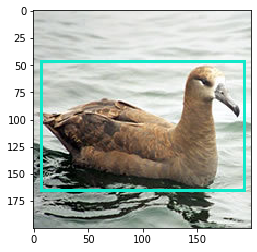

In [11]:
bbox_plot(5)

87 474 74 325


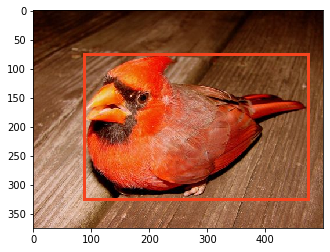

In [12]:
bbox_plot(13)

## Initial configurations

## Region Proposal System

In [13]:
#https://towardsdatascience.com/region-proposal-network-a-detailed-view-1305c7875853
#https://medium.com/egen/region-proposal-network-rpn-backbone-of-faster-r-cnn-4a744a38d7f9
#https://towardsdatascience.com/faster-r-cnn-object-detection-implemented-by-keras-for-custom-data-from-googles-open-images-125f62b9141a

#https://www.pyimagesearch.com/2018/09/03/semantic-segmentation-with-opencv-and-deep-learning/
#https://www.learnopencv.com/selective-search-for-object-detection-cpp-python/
#http://www.huppelen.nl/publications/selectiveSearchDraft.pdf

We're going to be using OpenCVs selective search segmentation algorithm. We will want to consider what kind of color scale we will use here. FOr now lets import in color.

In [14]:
#Selective search for object recognition. International journal of computer vision,

In [15]:
image = cv2.imread('.'+test1['root'][13]+test1['filename'][13])
image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

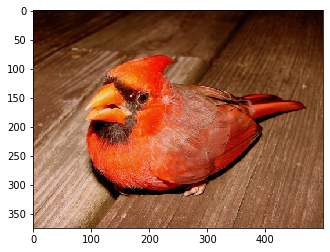

In [16]:
plt.imshow(image)

In [17]:
cv2.setUseOptimized(True)

In [18]:

ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(image)


In [19]:
ss.switchToSelectiveSearchQuality()
rects = ss.process()

In [20]:
len(rects)

1861

In [21]:
rects[:10]

array([[106, 266,  16,  18],
       [369, 124, 131, 251],
       [ 91, 115, 116, 134],
       [ 94, 229,   9,  59],
       [ 95, 230, 285,  98],
       [ 92,  70,  42,  27],
       [354, 178,  10,  15],
       [261, 186, 152, 135],
       [138, 320,  23,  17],
       [395, 297,  39,  78]], dtype=int32)

rects return x1,y1, w,h

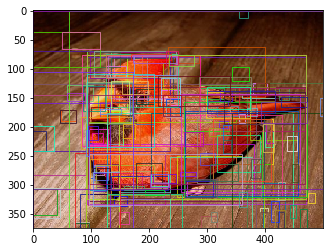

In [22]:
imOut = image.copy()
fig,ax = plt.subplots(1)
for i, rect in enumerate(rects):


    if (i < 200):

        x, y, w, h = rect
        #print(x,y,w,h)
        box=patches.Rectangle((x,y),w,h,linewidth=0.8,edgecolor=np.random.rand(3,),facecolor='none')
        ax.add_patch(box)
        #print(x,y,w,h)
        



plt.imshow(imOut)

In [23]:
rects = list(filter(lambda x : x[2]<x[3]*3 and x[3]<x[2]*3, rects))

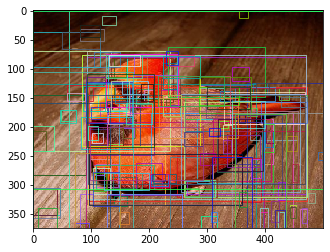

In [24]:
imOut = image.copy()
fig,ax = plt.subplots(1)
for i, rect in enumerate(rects):


    if (i < 200):

        x, y, w, h = rect
        #print(x,y,w,h)
        box=patches.Rectangle((x,y),w,h,linewidth=0.8,edgecolor=np.random.rand(3,),facecolor='none')
        ax.add_patch(box)
        #print(x,y,w,h)
        



plt.imshow(imOut)

## Calculate Intersection over Unioin

In [25]:
#https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/

The IoU is a commonly used ratio or 'score' with how overlapped the proposed regions with our ground truth boxes. This is a common technique in pretty much every version of region-based CNNs. A score of 1 is one box totally overlaps the other, and 0 is there is no overlap. For our boundary box regression? problem, we will assign 1 to regions with a score of over 0.7 and 0 to regions with an IoU score of 0.3 and assignt nothing to those inbetween. We will also pass along our strong iou score windows for Feature Mapping(CNN).

Mean Average Precision
precisions: List of precisions at different class score thresholds.
recalls: List of recall values at different class score thresholds.
overlaps: pred_boxes, gt_boxes IoU overlaps.

The thing is smaller boxes still totally INSIDE the ground truth box will stll have LOW scores if they are way smaller than the ground truth box ...

In [26]:
def calc_iou(box1,box2):

    
    left_max=max(box1['x1'],box2['x1'])
    right_min=min(box1['x2'],box2['x2'])
    top_min=min(box1['y2'],box2['y2'])
    bottom_max=max(box1['y1'],box2['y1'])
    if right_min < left_max or top_min < bottom_max:
        return 0.0
    
    
    
    area_of_intersect=(right_min-left_max)*(top_min-bottom_max)
    area_of_union=((box1['y2']-box1['y1'])*(box1['x2']-box1['x1']))+((box2['y2']-box2['y1'])*(box2['x2']-box2['x1']))-area_of_intersect
    iou=(area_of_intersect)/(area_of_union)
    assert iou >= 0.0
    assert iou <= 1.0

    return iou



Were going to loop through each image, get the ground truth box, run segmentation, utilize our IoU function, label regions with 1 for high iou and 0 for low iou and save all to list. We then do a binary classification problem on these regions 

In [27]:

image = cv2.imread('.'+train1['root'][0]+train1['filename'][0])
image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(image)
ss.switchToSelectiveSearchFast()
rects = ss.process()
rects = list(filter(lambda x : x[2]<x[3]*3 and x[3]<x[2]*3, rects))

In [28]:
len(rects)

400

In [29]:
box1={}
box1['x1']=round(float(train1['x1'][0]))
box1['x2']=round(float(train1['x2'][0]))
box1['y1']=round(float(train1['y1'][0]))
box1['y2']=round(float(train1['y2'][0]))

In [30]:
box1['w']=round(float(train1['w'][0]))
box1['h']=round(float(train1['h'][0]))


In [31]:
#rects = list(filter(lambda x : x[0]+x[2]<box1['w'], rects))

In [32]:
rects = list(filter(lambda x : x[2]<x[3]*3 and x[3]<x[2]*3, rects))

In [33]:
if (box1['x2']-box1['x1'])>(box1['y2']-box1['y1']):
    rects = list(filter(lambda x : x[2]>x[3], rects))
else:
    rects = list(filter(lambda x : x[2]<=x[3], rects))


In [34]:
# box1={}
# box1['x1']=round(float(test1['wing'][1]['xtl']))
# box1['x2']=round(float(test1['wing'][1]['xbr']))
# box1['y1']=round(float(test1['wing'][1]['ytl']))
# box1['y2']=round(float(test1['wing'][1]['ybr']))

0.9339688157006003
0.7650794210772338
0.7824352858371784
0.8600054899807851
0.8328830260648442
0.9030614272091545
0.7133786848072562
0.8457280548109584
0.8385935769656699
0.7690502727752684
0.8410680228862047
0.8369755244755245
0.8204369040778363
0.7052655573284705
0.7131800591850671
0.7085585585585585
0.8727550858232677
0.7105442951491687
0.8485775588048315
0.8444811450591797
0.9247159090909091


Text(0.5, 1.0, 'Proposed Regions w. IoU > 0.7')

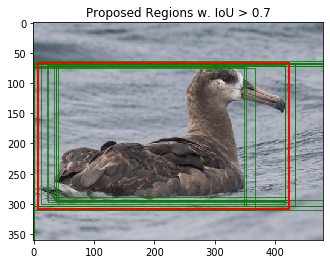

In [35]:

fig,ax = plt.subplots(1)
for i,item in enumerate(rects):
    box2={}
    box2['x1']=rects[i][0]
    box2['y1']=rects[i][1]
    box2['x2']=rects[i][0]+rects[i][2]
    box2['y2']=rects[i][1]+rects[i][3]
    iou=calc_iou(box1,box2)
    if iou>0.7:
        #print(iou,i,item)



        x, y, w, h = rects[i]
        #print(x,y,w,h)
        box=patches.Rectangle((x,y),w,h,linewidth=0.8,edgecolor='green',facecolor='none')
        ax.add_patch(box)
        box3=patches.Rectangle((box1['x1'],box1['y1']),box1['x2']-box1['x1'],box1['y2']-box1['y1'],linewidth=2,edgecolor='red',facecolor='none')
        ax.add_patch(box3)
        print(iou)
plt.imshow(image)
plt.title('Proposed Regions w. IoU > 0.7')

rects[50]

In [36]:
print(box2)
print(box1)

{'x1': 0, 'y1': 154, 'x2': 480, 'y2': 360}
{'x1': 7, 'x2': 423, 'y1': 67, 'y2': 309, 'w': 480, 'h': 360}


In [37]:
calc_iou(box1,box2)

0.4773750296138356

#### WARNING Long Process time

This tidbit of code

In [38]:
train_images=[]
train_labels=[]
iou_scores=[]

In [39]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [40]:
##code adopted from 
##https://towardsdatascience.com/step-by-step-r-cnn-implementation-from-scratch-in-python-e97101ccde55
for i,item in enumerate(train1['filename']):
    try:

#     box1={}
#     box1['x1']=round(float(train1['wing'][i]['xtl']))
#     box1['x2']=round(float(train1['wing'][i]['xbr']))
#     box1['y1']=round(float(train1['wing'][i]['ytl']))
#     box1['y2']=round(float(train1['wing'][i]['ybr']))
    
#     box2={}
#     box2['x1']=round(float(train1['head'][i]['xtl']))
#     box2['x2']=round(float(train1['head'][i]['xbr']))
#     box2['y1']=round(float(train1['head'][i]['ytl']))
#     box2['y2']=round(float(train1['head'][i]['ybr']))
        box1={}
        box1['x1']=round(float(train1['x1'][i]))
        box1['x2']=round(float(train1['x2'][i]))
        box1['y1']=round(float(train1['y1'][i]))
        box1['y2']=round(float(train1['y2'][i]))
        
        
        
        image = cv2.imread('.'+train1['root'][i]+train1['filename'][i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        
        ss.setBaseImage(image)
        ss.switchToSelectiveSearchQuality()
        rects = ss.process()
        rects = list(filter(lambda x : x[2]<x[3]*3 and x[3]<x[2]*3, rects))
#         if (box1['x2']-box1['x1'])>(box1['y2']-box1['y1']):
#             rects = list(filter(lambda x : x[2]>x[3], rects))
#         else:
#             rects = list(filter(lambda x : x[2]<=x[3], rects))
    
#         rects = list(filter(lambda x : x[2]<x[3]*3 and x[3]<x[2]*3, rects))
        
        imout=image.copy()
        
        counter1=0
        counter2=0
        flag=0
        fflag=0
        bflag=0
        for j,item in enumerate(rects):
            if j<2000 and flag==0:
                box3={}
                box3['x1']=rects[j][0]
                box3['y1']=rects[j][1]
                box3['x2']=rects[j][0]+rects[j][2]
                box3['y2']=rects[j][1]+rects[j][3]
                iou_score=calc_iou(box1,box3)
                if counter1<30:
                    if iou_score>0.7:
                        timage=imout[box3['y1']:box3['y2'],box3['x1']:box3['x2']]
                        resized=cv2.resize(timage,(224,224),interpolation=cv2.INTER_AREA)
                        train_images.append(resized)
                        train_labels.append(1)
                        counter1+=1
                        print('yes')
                else:
                    fflag=1
                if counter2<30:
                    if iou_score<0.3:
                        timage=imout[box3['y1']:box3['y2'],box3['x1']:box3['x2']] 
                        resized=cv2.resize(timage,(224,224),interpolation=cv2.INTER_AREA)
                        train_images.append(resized)
                        train_labels.append(0)
                        counter2+=1
                
                else:
                    bflag=1
                    
            if fflag==1 and bflag==1:
                print('inside')
                flag=1
    except Exception as j:
        print(j)
            
            
            
    
            
        

yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
insid

yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
insid

yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
insi

yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
insid

yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
insid

yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
insid

yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
insid

yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
in

In [41]:
test_images=[]
test_labels=[]

In [42]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [43]:
for i,item in enumerate(test1['filename']):
    try:

#     box1={}
#     box1['x1']=round(float(test1['wing'][i]['xtl']))
#     box1['x2']=round(float(test1['wing'][i]['xbr']))
#     box1['y1']=round(float(test1['wing'][i]['ytl']))
#     box1['y2']=round(float(test1['wing'][i]['ybr']))
    
#     box2={}
#     box2['x1']=round(float(test1['head'][i]['xtl']))
#     box2['x2']=round(float(test1['head'][i]['xbr']))
#     box2['y1']=round(float(test1['head'][i]['ytl']))
#     box2['y2']=round(float(test1['head'][i]['ybr']))
        box1={}
        box1['x1']=round(float(test1['x1'][i]))
        box1['x2']=round(float(test1['x2'][i]))
        box1['y1']=round(float(test1['y1'][i]))
        box1['y2']=round(float(test1['y2'][i]))
        
        
        
        image = cv2.imread('.'+test1['root'][i]+test1['filename'][i])

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ss.setBaseImage(image)

        
        ss.switchToSelectiveSearchQuality()
        rects = ss.process()
        rects = list(filter(lambda x : x[2]<x[3]*3 and x[3]<x[2]*3, rects))
#         if (box1['x2']-box1['x1'])>(box1['y2']-box1['y1']):
#             rects = list(filter(lambda x : x[2]>x[3], rects))
#         else:
#             rects = list(filter(lambda x : x[2]<=x[3], rects))
    
#         rects = list(filter(lambda x : x[2]<x[3]*3 and x[3]<x[2]*3, rects))
        
        imout=image.copy()
        
        counter1=0
        counter2=0
        flag=0
        fflag=0
        bflag=0
        for j,item in enumerate(rects):
            if j<2000 and flag==0:
                box3={}
                box3['x1']=rects[j][0]
                box3['y1']=rects[j][1]
                box3['x2']=rects[j][0]+rects[j][2]
                box3['y2']=rects[j][1]+rects[j][3]
                iou_score=calc_iou(box1,box3)
                if counter1<30:
                    if iou_score>0.7:
                        timage=imout[box3['y1']:box3['y2'],box3['x1']:box3['x2']]
                        resized=cv2.resize(timage,(224,224),interpolation=cv2.INTER_AREA)
                        test_images.append(resized)
                        test_labels.append(1)
                        counter1+=1
                        print('yes')
                else:
                    fflag=1
                if counter2<30:
                    if iou_score<0.3:
                        timage=imout[box3['y1']:box3['y2'],box3['x1']:box3['x2']] 
                        resized=cv2.resize(timage,(224,224),interpolation=cv2.INTER_AREA)
                        test_images.append(resized)
                        test_labels.append(0)
                        counter2+=1
                
                else:
                    bflag=1
                    
            if fflag==1 and bflag==1:
                print('inside')
                flag=1
    except Exception as j:
        print(j)
            
    

yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
insi

yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
insid

yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
insid

yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
i

## Modeling

In [44]:
count=0
for i in test_labels:
    if i==0:
        count+=1
print(count)

750


In [45]:
print(len(train_images))
print(len(train_labels))

2175
2175


In [46]:
print(len(test_images))
print(len(test_labels))

1325
1325


In [47]:
X_train=np.array(train_images)

In [48]:
X_train.shape

(2175, 224, 224, 3)

In [49]:
y_train=np.array(train_labels)

In [50]:
X_test=np.array(test_images)

In [51]:
y_test=np.array(test_labels)

In [52]:
from sklearn.metrics import accuracy_score


In [53]:
X_train.shape

(2175, 224, 224, 3)

In [54]:
X_test.shape

(1325, 224, 224, 3)

In [55]:
# nsamples, nx, ny = X_train.shape
# X_train = X_train.reshape((nsamples,nx*ny))

ValueError: too many values to unpack (expected 3)

In [ ]:
nsamples, nx, ny = X_test.shape
X_test = X_test.reshape((nsamples,nx*ny))

In [70]:
from sklearn.preprocessing import LabelBinarizer


In [71]:

class MyLabelBinarizer(LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y
    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)

In [73]:
lenc = MyLabelBinarizer()
y_train =  lenc.fit_transform(y_train)

In [74]:

y_test =  lenc.transform(y_test)

In [ ]:

# trdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
# traindata = trdata.flow(x=X_train, y=y_train)
# tsdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
# testdata = tsdata.flow(x=X_test, y=y_test)

In [ ]:
X_train

In [ ]:
svc = SVC(gamma="scale")

In [ ]:
svc.fit(X_train, y_train)

In [ ]:
X_test.shape

In [ ]:
%%time
y_pred = svc.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred)

In [ ]:
knn = KNeighborsClassifier()


In [ ]:
knn.fit(X_train, y_train)

In [ ]:
%%time
y_pred = knn.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred)

## RGB Object Detector with CNN

In [56]:
X_train.shape

(2175, 224, 224, 3)

In [75]:


cnn = Sequential()
cnn.add(Conv2D(filters=32, 
               kernel_size=(2,2), 
               strides=(1,1),
               padding='same',
               input_shape=(224,224,3),
               data_format='channels_last'))
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size=(2,2),
                     strides=2))
cnn.add(Conv2D(filters=64,
               kernel_size=(2,2),
               strides=(1,1),
               padding='valid'))
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size=(2,2),
                     strides=2))
cnn.add(Flatten())        
cnn.add(Dense(64))
cnn.add(Activation('relu'))
cnn.add(Dropout(0.25))
cnn.add(Dense(2))
cnn.add(Activation('sigmoid'))


In [76]:
cnn.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [77]:
history = cnn.fit(X_train,
                        y_train,
                        batch_size=256,
                        validation_data=(X_test, y_test),
                        epochs=10,
                        verbose=1)

Train on 2175 samples, validate on 1325 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
2175/2175 [==============================] - 84s 39ms/sample - loss: 8.5170 - acc: 0.4605 - val_loss: 9.0737 - val_acc: 0.4340
Epoch 2/10
2175/2175 [==============================] - 81s 37ms/sample - loss: 9.2131 - acc: 0.4251 - val_loss: 9.0737 - val_acc: 0.4340
Epoch 3/10
2175/2175 [==============================] - 82s 38ms/sample - loss: 9.2052 - acc: 0.4257 - val_loss: 9.0737 - val_acc: 0.4340
Epoch 4/10


KeyboardInterrupt: 

In [ ]:
# clf=LinearSVC(random_state=1881)

In [ ]:
#https://www.pyimagesearch.com/2014/11/17/non-maximum-suppression-object-detection-python/

In [ ]:
#https://gist.github.com/CMCDragonkai/1be3402e261d3c239a307a3346360506

In [ ]:
image = cv2.imread('.'+test1['root'][1]+test1['filename'][1])

image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        
ss.switchToSelectiveSearchQuality()
rects = ss.process()

## Negative hard mining

In [ ]:
test1['root'][1]+test1['filename'][1]

In [ ]:
image = cv2.imread('.'+test1['root'][13]+test1['filename'][13])
image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [ ]:

ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(image)

In [ ]:
ss.switchToSelectiveSearchQuality()
rects = ss.process()

In [ ]:
plt.imshow(image)

In [ ]:
test_sample=[]
imout=image.copy()
for i,item in enumerate(rects):
    x1=rects[i][0]
    y1=rects[i][1]
    x2=rects[i][0]+rects[i][2]
    y2=rects[i][1]+rects[i][3]
    cimage=imout[y1:y2,x1:x2]
    cimage=cv2.resize(cimage,(224,224),interpolation=cv2.INTER_AREA)
    test_sample.append(cimage)
    

In [ ]:
type(test_sample)

In [ ]:
test_sample_array=np.array(test_sample)

In [ ]:
test_sample_array.shape

In [ ]:
nsamples, nx, ny = test_sample_array.shape
test_sample = test_sample_array.reshape((nsamples,nx*ny))

In [ ]:
test_preds=svc.predict(test_sample)

In [ ]:
test_preds

In [ ]:
fore=[]
for sample,label in zip(rects,test_preds):
    if label==1:
        fore.append(sample)
    

In [ ]:
for i in fore:
    x,y,w,h=i
    print(x)

In [ ]:
image = cv2.imread('.'+test1['root'][12]+test1['filename'][12])
image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
imOut = image.copy()
fig,ax = plt.subplots(1)
for i in fore:
    x, y, w, h = i
    
    print(x,y,w,h)
    box=patches.Rectangle((x,y),w,h,linewidth=1.5,edgecolor='green',facecolor='none')
    ax.add_patch(box)
               #print(x,y,w,h)
               



plt.imshow(imOut)

## VGG16

VGG16 is a popular CNN framework we will impliment here

In [ ]:
##https://github.com/keras-team/keras-applications/blob/master/keras_applications/vgg16.py
input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=32,
                                      data_format=backend.image_data_format(),
                                      require_flatten=include_top,
                                      weights=weights)

if input_tensor is None:
        img_input = layers.Input(shape=input_shape)
else:
    if not backend.is_keras_tensor(input_tensor):
            img_input = layers.Input(tensor=input_tensor, shape=input_shape)
    else:
            img_input = input_tensor
    # Block 1
x=Conv2D(64, (3, 3),activation='relu',padding='same',name='block1_conv1')(img_input)
x=Conv2D(64, (3, 3),activation='relu',padding='same',name='block1_conv2')(x)
x=MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

# Block 2
x=Conv2D(128, (3, 3),activation='relu',padding='same',name='block2_conv1')(x)
x=Conv2D(128, (3, 3), activation='relu',padding='same',name='block2_conv2')(x)
x=MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

# Block 3
x=Conv2D(256, (3, 3),activation='relu',padding='same',name='block3_conv1')(x)
x=Conv2D(256, (3, 3),activation='relu',padding='same',name='block3_conv2')(x)
x=Conv2D(256, (3, 3),activation='relu',padding='same',name='block3_conv3')(x)
x=MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

# # Block 4
# x=Conv2D(512, (3, 3),activation='relu',padding='same',name='block4_conv1')(x)
# x=Conv2D(512, (3, 3),activation='relu',padding='same',name='block4_conv2')(x)
# x=Conv2D(512, (3, 3),activation='relu',padding='same',name='block4_conv3')(x)
# x=MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

# # Block 5
# x=Conv2D(512, (3, 3), activation='relu',padding='same',name='block5_conv1')(x)
# x=Conv2D(512, (3, 3), activation='relu',padding='same',name='block5_conv2')(x)
# x=Conv2D(512, (3, 3),activation='relu', padding='same', name='block5_conv3')(x)
# x=MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

In [ ]:
# rects = ss.process()
# numShowRects = 100
# increment = 50
# imOut = image.copy()
# for i, rect in enumerate(rects):
#     if (i < numShowRects):

#         x, y, w, h = rect
#         patches.Rectangle((x,y),x+w,y+h,linewidth=1,edgecolor=np.random.rand(3,),facecolor='none')
#         #cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
    
# cv2.imshow("Output", imOut)


#     rect = 


In [ ]:
def bili_pooling(x):
    shp = K.shape(x)
    bsz, w, h, c = shp[0], shp[1], shp[2], shp[3]
    
    # Bilinear pooling
    b1 = K.reshape(x, (bsz * w * h, c, 1))
    b2 = K.reshape(x, (bsz * w * h, 1, c))
    d  = K.reshape(K.batch_dot(b1, b2), (bsz, w * h, c, c))
    d = K.sum(d, 1)
    
    # Flatten
    d = K.reshape(d, (bsz, c * c))
    
    # Normalize
    d = K.sqrt(K.relu(d))
    d = K.l2_normalize(d, -1)
    return d

In [ ]:
     
    #https://stackoverflow.com/questions/25349178/calculating-percentage-of-bounding-box-overlap-for-image-detector-evaluation